<a href="https://colab.research.google.com/github/AdharshReddyC/azure-cost-forecasting/blob/main/Azure_cost_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Azure Cost Forecasting using Time Series Models**

## **1. Data Loading and Preprocessing**  
- Loaded Azure cost data using Pandas.  
- Parsed date columns and set them as the index.  
- Handled missing values and ensured data consistency.  

---

## **2. Exploratory Data Analysis (EDA)**  
- Visualized the time series data to understand patterns and trends.  
- Identified seasonality, trend, and cyclic components using decomposition.  

---

## **3. Time Series Forecasting Models**  

### **(a) ARIMA/SARIMA**  
- Built a ARMIA and SARIMA models with optimized seasonal parameters.  
- Captured both trend and seasonality components.  
- Forecasted future values and plotted the results.  
- Evaluated model performance using:  
  - **MSE:** 419.19  
  - **RMSE:** 20.47  
  - **MAPE:** 13.25%  

---

### **(b) Prophet Model**  
- Built a Prophet model with weekly seasonality.  
- Forecasted future costs and plotted the results.  
- Evaluated model performance using:  
  - **MSE:** 247.40  
  - **RMSE:** 15.73
  



---

## **4. Conclusion**  
- Prophet performed the best with the lowest MSE  
- SARIMA provided reasonably good results but was outperformed by Prophet.  


### Importing Libraries

In [353]:
import pandas as pd
import numpy as np
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt



In [354]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Data Preprocessing

### Reading data

In [355]:
data = pd.read_csv('/content/anonymized_costs.csv')
print(data.head())

                                  InvoiceSectionName        Date  \
0  bc05844fb9454a82a5380ad11fceccc59227e495d31ab1...  12/31/2022   
1  bc05844fb9454a82a5380ad11fceccc59227e495d31ab1...  12/31/2022   
2  bc05844fb9454a82a5380ad11fceccc59227e495d31ab1...  12/31/2022   
3  bc05844fb9454a82a5380ad11fceccc59227e495d31ab1...  12/31/2022   
4  bc05844fb9454a82a5380ad11fceccc59227e495d31ab1...  12/31/2022   

       MeterCategory  CostInBillingCurrency            MeterSubCategory  \
0  Azure App Service               0.000000                   Free Plan   
1      Load Balancer               0.018600                    Standard   
2            Storage               0.000004                      Tables   
3      Load Balancer               0.018600                    Standard   
4            Storage               0.014312  Standard SSD Managed Disks   

                                       MeterName  \
0                                         F1 App   
1  Standard Included LB Rules and Ou

### Display basic info

In [356]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93605 entries, 0 to 93604
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   InvoiceSectionName     93605 non-null  object 
 1   Date                   93605 non-null  object 
 2   MeterCategory          93605 non-null  object 
 3   CostInBillingCurrency  93605 non-null  float64
 4   MeterSubCategory       93605 non-null  object 
 5   MeterName              93605 non-null  object 
 6   SubscriptionName       93605 non-null  object 
 7   ResourceGroup          93605 non-null  object 
 8   ConsumedService        93605 non-null  object 
 9   ResourceLocation       93605 non-null  object 
 10  ResourceName           93605 non-null  object 
dtypes: float64(1), object(10)
memory usage: 7.9+ MB
None


### Converting Date column to Datetime format

In [357]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')


### Checking for null values and dropping them

In [358]:
print(data.isnull().sum())

InvoiceSectionName       0
MeterCategory            0
CostInBillingCurrency    0
MeterSubCategory         0
MeterName                0
SubscriptionName         0
ResourceGroup            0
ConsumedService          0
ResourceLocation         0
ResourceName             0
dtype: int64


In [359]:
data = data.dropna()
print(data.shape)


(93605, 10)


###

# Exploratory Data Analysis

### Description of the data

In [360]:
data.describe()

,CostInBillingCurrency
count,93605.000000
mean,0.101932
std,0.465012
min,0.000000
25%,0.000002
50%,0.001696
75%,0.028190
max,26.902857


### Top 10 Categories used in the given data

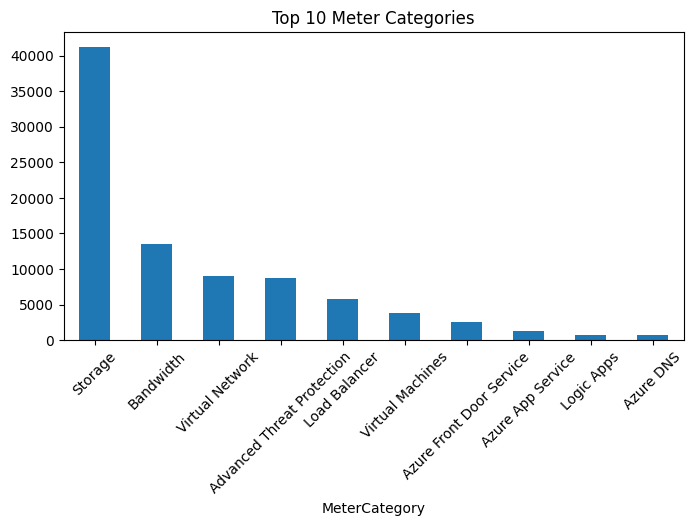

In [361]:
plt.figure(figsize=(8, 4))
data['MeterCategory'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Meter Categories')
plt.xticks(rotation=45)
plt.show()


### Visualizing Costs over time

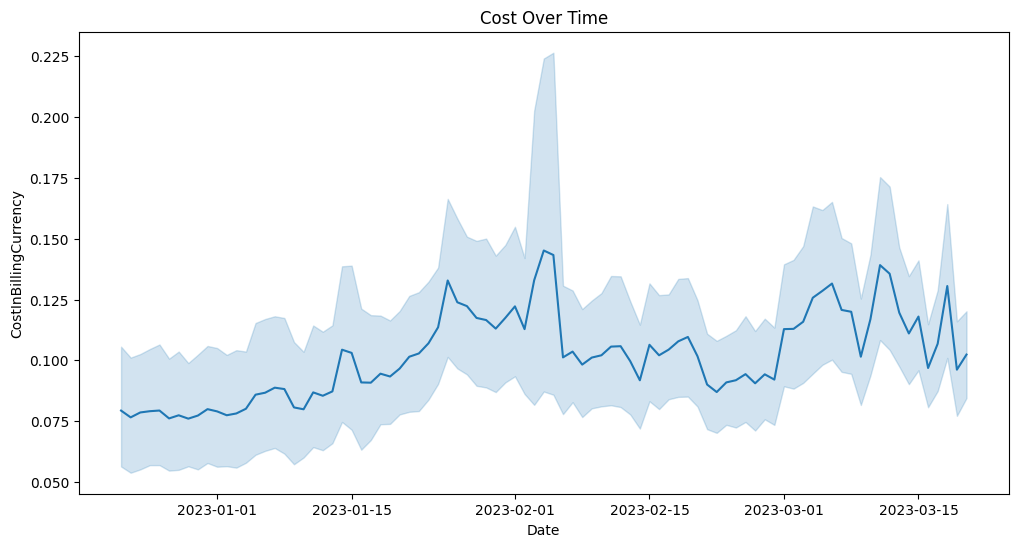

In [362]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='CostInBillingCurrency', data=data)
plt.title('Cost Over Time')
plt.show()


### Mean cost for each Meter Category

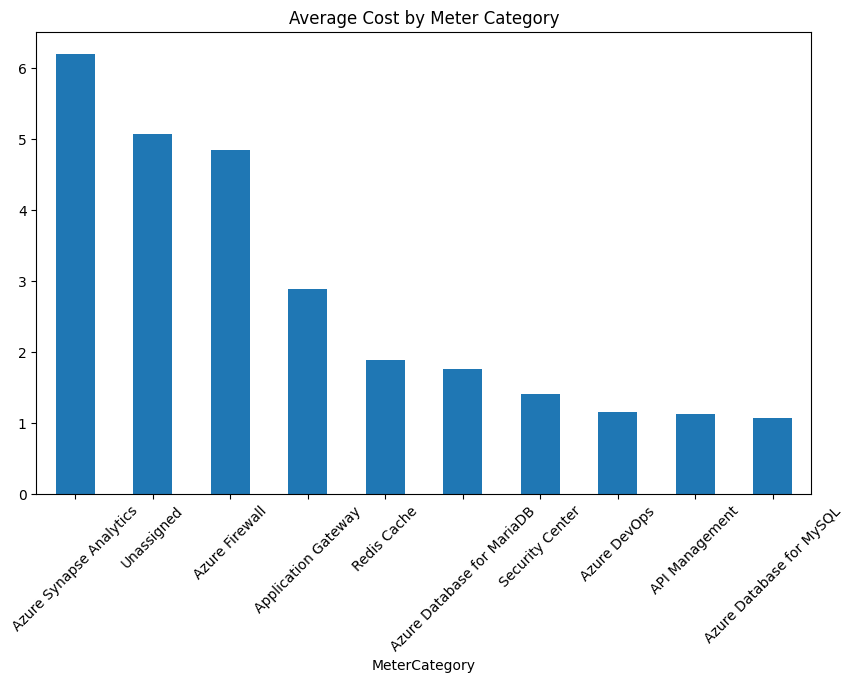

In [363]:
plt.figure(figsize=(10, 6))
avg_cost_by_category = data.groupby('MeterCategory')['CostInBillingCurrency'].mean().sort_values(ascending=False)
avg_cost_by_category.head(10).plot(kind='bar')
plt.title('Average Cost by Meter Category')
plt.xticks(rotation=45)
plt.show()


### Sum of daily costs incurred over time

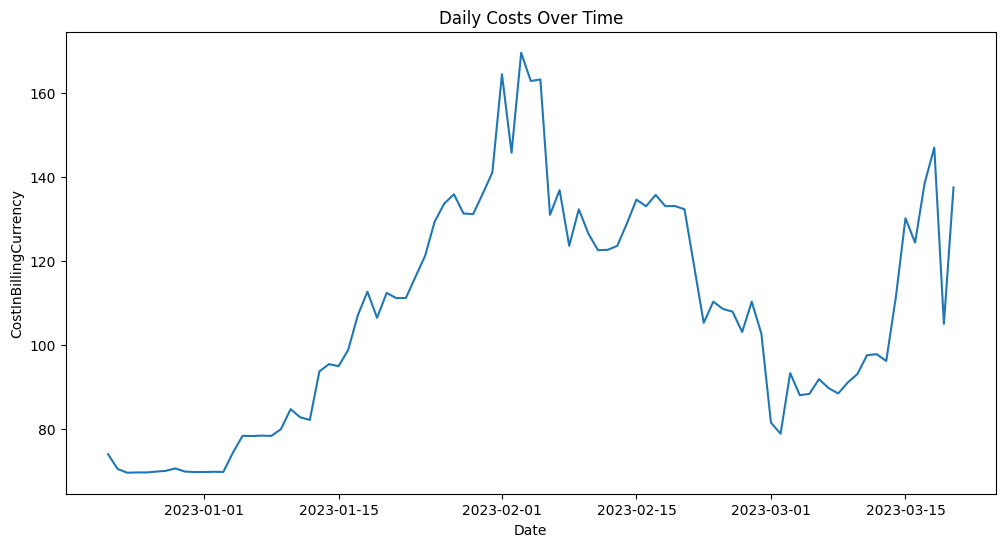

In [364]:
daily_cost = data['CostInBillingCurrency'].resample('D').sum()

plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_cost.index, y=daily_cost)
plt.title('Daily Costs Over Time')
plt.show()


### Sum of daily costs incurred over time for top 10 meter categories

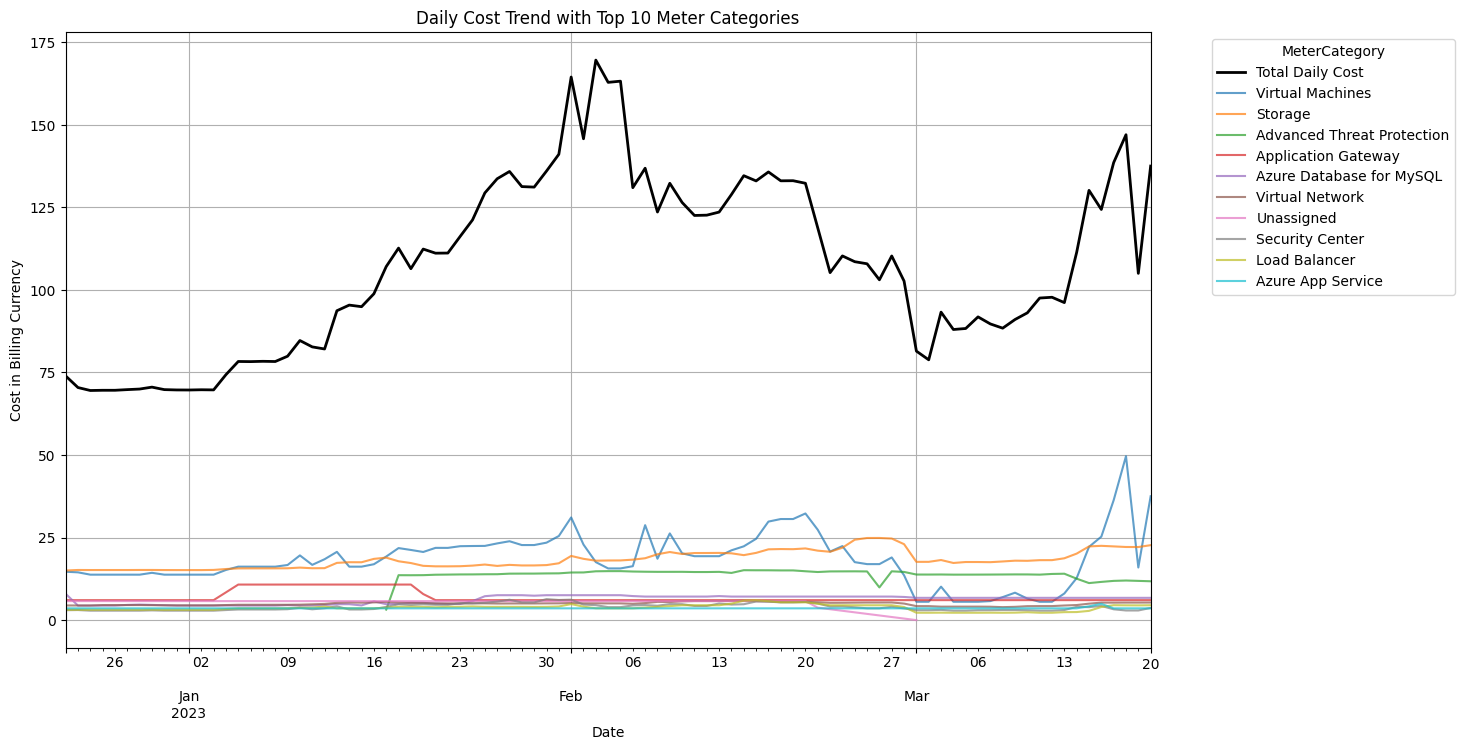

In [365]:
# top 10 MeterCategory by total cost
top_10_categories = data.groupby('MeterCategory')['CostInBillingCurrency'].sum().nlargest(10).index

# Plot overall daily cost
plt.figure(figsize=(14, 8))
data.groupby('Date')['CostInBillingCurrency'].sum().plot(label='Total Daily Cost', color='black', linewidth=2)

for category in top_10_categories:
    category_data = data[data['MeterCategory'] == category].groupby('Date')['CostInBillingCurrency'].sum()
    category_data.plot(label=category, alpha=0.7)

plt.title('Daily Cost Trend with Top 10 Meter Categories')
plt.xlabel('Date')
plt.ylabel('Cost in Billing Currency')
plt.legend(title='MeterCategory', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


#Making the time series stationary

### Decomposing

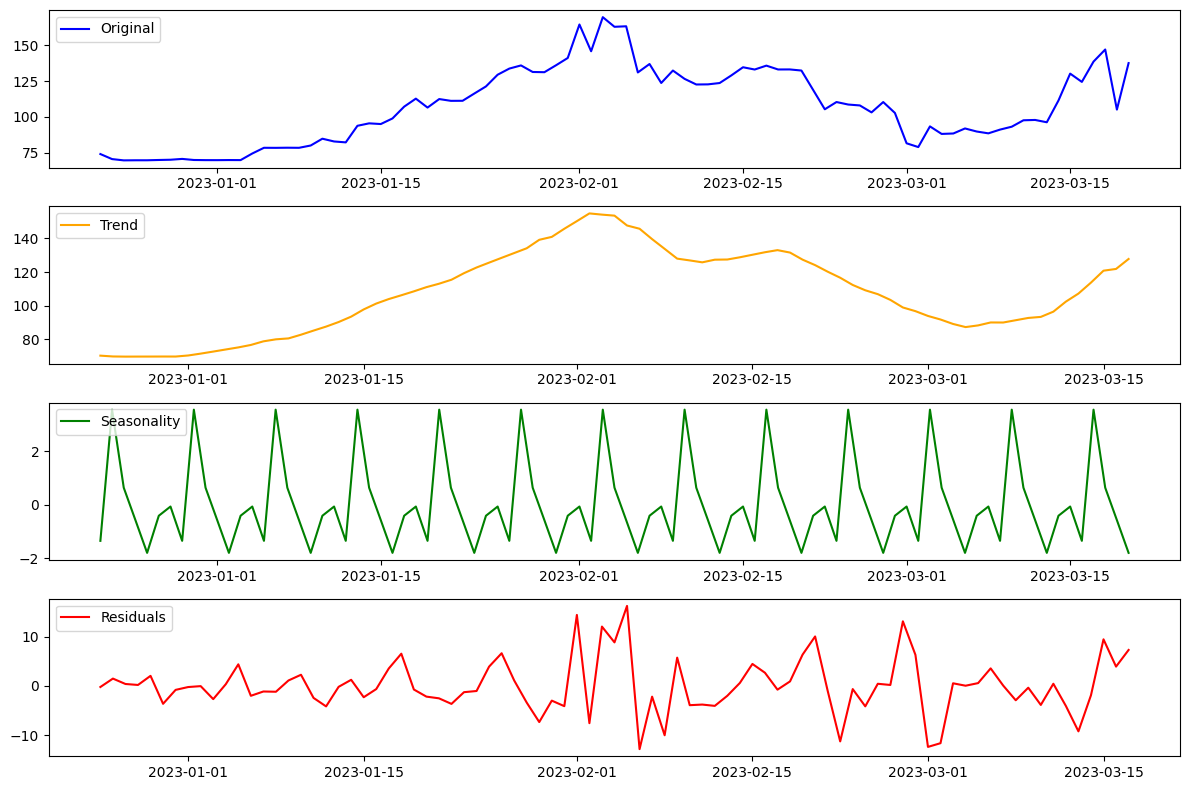

In [366]:
decomposition = seasonal_decompose(daily_cost, model='additive', period=7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(daily_cost, label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Checking the stationarity using dicky fuller test

In [367]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Data is stationary.")
    else:
        print("Data is non-stationary.")


In [368]:
adf_test(daily_cost)


p-value: 0.5409078904772467
Data is non-stationary.


### Remove trend and seasonality with differencing

In [369]:
daily_cost_diff = daily_cost.diff().dropna()
adf_test(daily_cost_diff)


p-value: 6.770706999545286e-23
Data is stationary.


We can see that our series is now stationary

### Plot the autocorreltaion and partial auto correlation functions

Plotting the graphs and getting the p,q,d values for arima


<Figure size 1200x500 with 0 Axes>

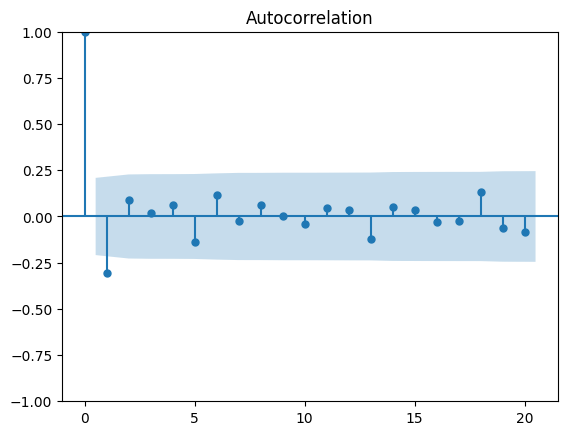

<Figure size 1200x500 with 0 Axes>

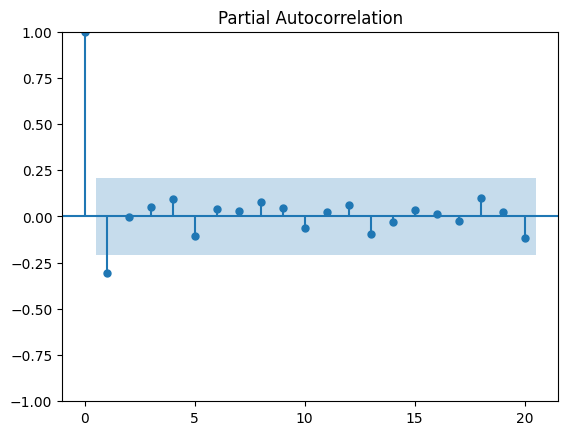

In [370]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))
plot_acf(daily_cost_diff, lags=20)  # Autocorrelation
plt.show()

plt.figure(figsize=(12, 5))
plot_pacf(daily_cost_diff, lags=20)  # Partial Autocorrelation
plt.show()


# ARIMA MODEL

In [371]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(1,1,1) on the original series
model = ARIMA(daily_cost, order=(1, 1, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


                                 SARIMAX Results                                 
Dep. Variable:     CostInBillingCurrency   No. Observations:                   89
Model:                    ARIMA(1, 1, 1)   Log Likelihood                -321.499
Date:                   Thu, 20 Mar 2025   AIC                            648.997
Time:                           17:36:03   BIC                            656.429
Sample:                       12-22-2022   HQIC                           651.991
                            - 03-20-2023                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4770      0.256     -1.864      0.062      -0.979       0.025
ma.L1          0.1468      0.257      0.571      0.568      -0.357       0.651
sigma2        87.1282      7

### Train-Test splitting the data and visualizing the forcast of ARIMA model

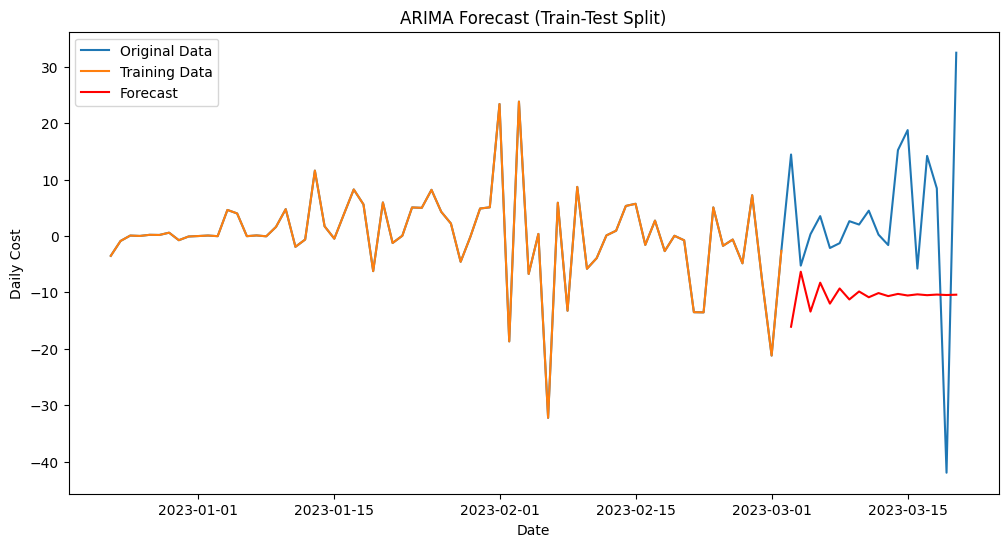

Mean Absolute Percentage Error (MAPE): 755.84%


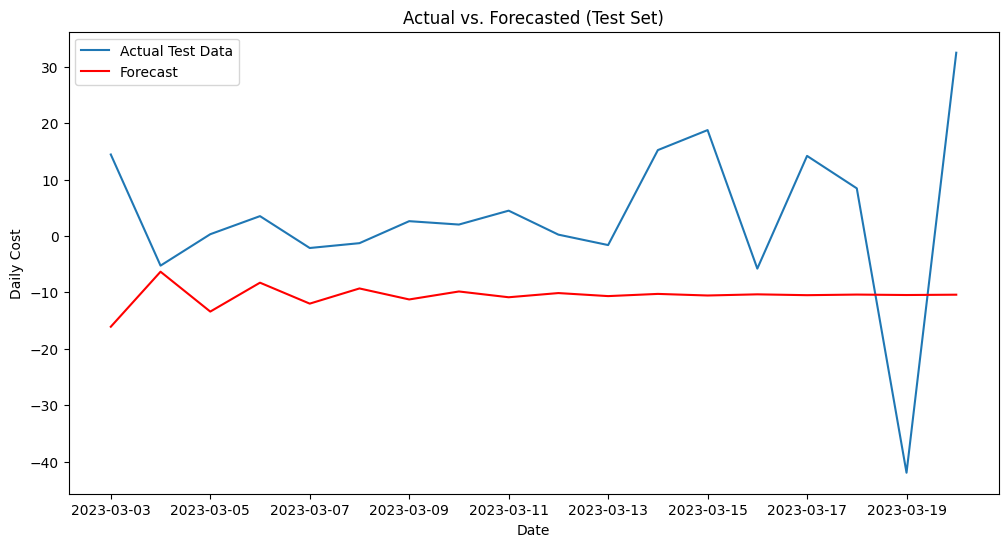

In [372]:

# Split the data into training and testing sets
train_size = int(len(daily_cost_diff) * 0.8)  # 80% for training, 20% for testing
train, test = daily_cost_diff[:train_size], daily_cost_diff[train_size:]

# Fit ARIMA
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit()

# Forecast for the test set
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

# Create a date range for the forecast
forecast_index = test.index

# Create a pandas Series for the forecast
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the original data, training data, and the forecast
plt.figure(figsize=(12, 6))
plt.plot(daily_cost_diff, label='Original Data')
plt.plot(train, label='Training Data')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast (Train-Test Split)')
plt.xlabel('Date')
plt.ylabel('Daily Cost')
plt.show()

# Calculate MAPE
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(test, forecast_series)

print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Plot the actual vs. forecasted in the test set
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual Test Data')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend()
plt.title('Actual vs. Forecasted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Daily Cost')
plt.show()

### Trying SARIMA model

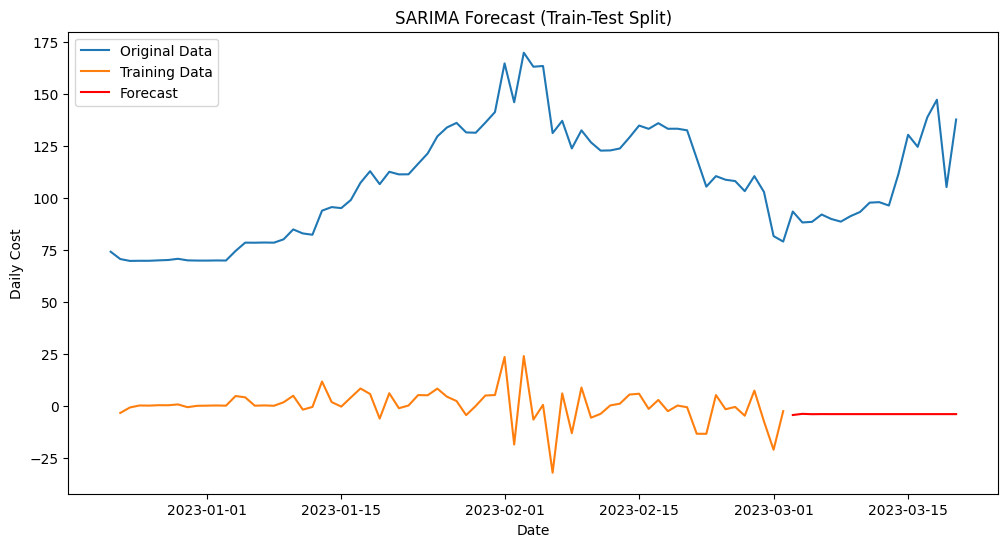

Mean Absolute Percentage Error (MAPE): 313.45%


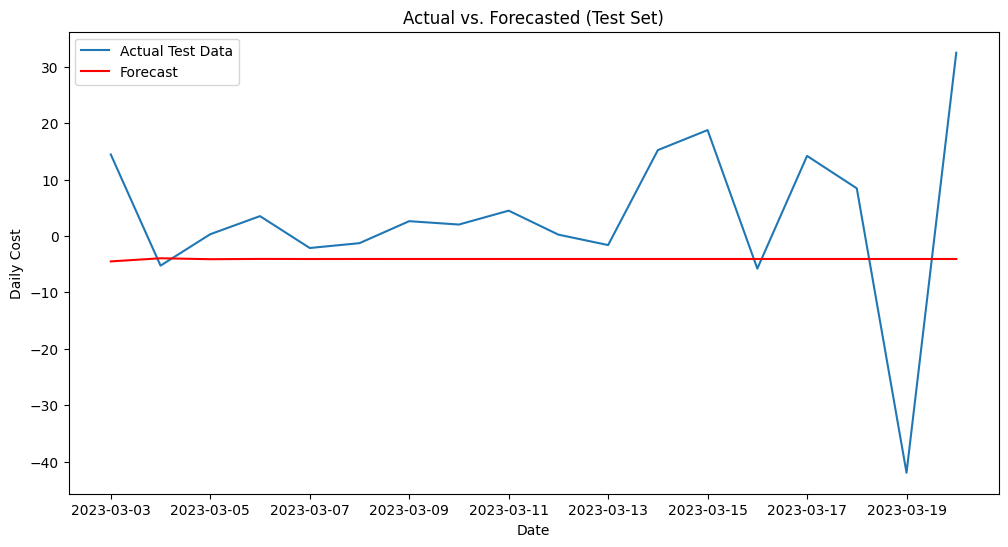

In [373]:

from statsmodels.tsa.statespace.sarimax import SARIMAX


p, d, q = 1, 1, 1
P, D, Q, m = 0, 0, 0, 7  # Assuming no seasonal AR, differencing, or MA for simplicity

model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m))
model_fit = model.fit()

# Forecast for the test set
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

# Create a date range for the forecast
forecast_index = test.index

# Create a pandas Series for the forecast
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the original data, training data, and the forecast
plt.figure(figsize=(12, 6))
plt.plot(daily_cost, label='Original Data')
plt.plot(train, label='Training Data')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend()
plt.title('SARIMA Forecast (Train-Test Split)')
plt.xlabel('Date')
plt.ylabel('Daily Cost')
plt.show()

# Calculate MAPE
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(test, forecast_series)

print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Plot the actual vs. forecasted in the test set
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual Test Data')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend()
plt.title('Actual vs. Forecasted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Daily Cost')
plt.show()

### Facebook Prophet

In [374]:
train = train.to_frame()
test = test.to_frame()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfewby8dp/3bgg4guu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfewby8dp/wj820hjn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13808', 'data', 'file=/tmp/tmpfewby8dp/3bgg4guu.json', 'init=/tmp/tmpfewby8dp/wj820hjn.json', 'output', 'file=/tmp/tmpfewby8dp/prophet_modelv5deeffz/prophet_model-20250320173633.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:36:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 247.40
RMSE: 15.73
MAPE: nan%


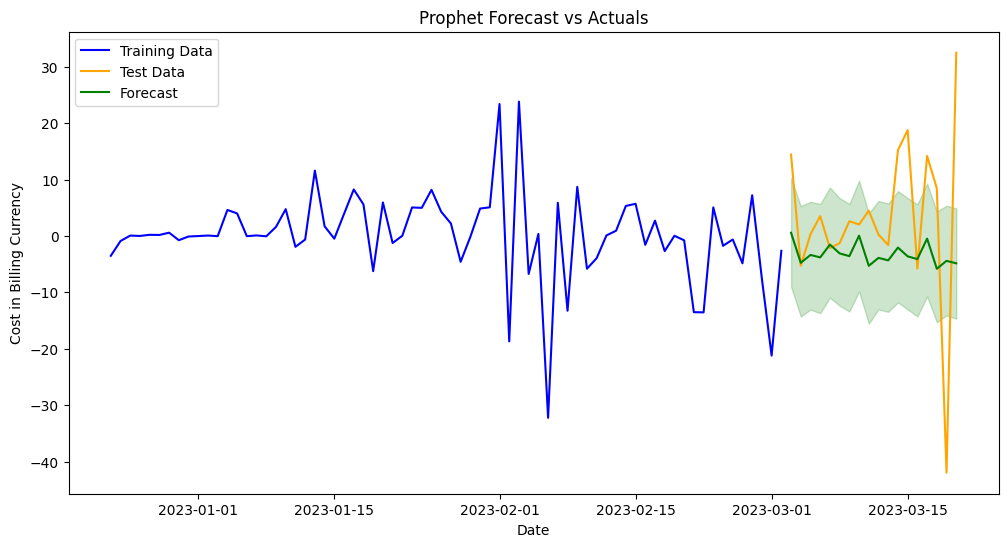

In [376]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error


# Prepare data for Prophet
train_prophet = train.reset_index()
train_prophet.columns = ['ds', 'y']

test_prophet = test.reset_index()
test_prophet.columns = ['ds', 'y']

# Initialize and fit the model with weekly seasonality
model = Prophet(weekly_seasonality=True)
model.fit(train_prophet)

# Create future dataframe for forecasting
future = model.make_future_dataframe(periods=len(test), freq='D')

# Forecast
forecast = model.predict(future)

# Extract relevant part for test set
forecast_test = forecast.set_index('ds').loc[test_prophet['ds']]

# Evaluation
mse = mean_squared_error(test_prophet['y'], forecast_test['yhat'])
rmse = np.sqrt(mse)

# Handle zeros in MAPE calculation
actual = test_prophet['y'].replace(0, np.nan)  # Replace 0 with NaN to avoid division errors
mape = np.mean(np.abs((actual - forecast_test['yhat']) / actual)) * 100

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Training Data', color='blue')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Test Data', color='orange')
plt.plot(forecast_test.index, forecast_test['yhat'], label='Forecast', color='green')
plt.fill_between(forecast_test.index, forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='green', alpha=0.2)
plt.title('Prophet Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Cost in Billing Currency')
plt.legend()
plt.show()
